In [32]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

from dynchro.tl import dtw, traceback, warp_pseudotime, dynchronize, get_kde_eval, get_wasserstein_distance, get_cutoff_kde
from dynchro.pl import plot_distance_matrix, plot_cost_matrix, plot_dtw_matrices, plot_kde_comparison

from utils import plot_iroot, comp_kde, kdeplot, kdeplot2, compare, norm, get_kdes_wasserstein

random.seed(34)
np.random.seed(34)

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Read in data

In [34]:
d1 = ad.read_h5ad("data/dynchro1_slingshot_processed.h5ad")
d2 = ad.read_h5ad("data/dynchro2_slingshot_processed.h5ad")
d2.obs["milestones"] = d2.obs.milestones.cat.rename_categories({'sC': 'sC_batch'})

In [35]:
d1.X = d1.layers["X"]
d2.X = d2.layers["X"]

# 2. Sort lineages

In [36]:
def get_sorted_lineage(d, pseudotime_col, lineage_col):
    lineage = d[d.obs[lineage_col] == "TRUE"]
    sorting = np.argsort(lineage.obs[pseudotime_col])
    sorted_lin = lineage[sorting, :]
    return sorted_lin

In [37]:
d1_linC = get_sorted_lineage(d1, "orig_linC_pseudotime", "linC")
d1_linD = get_sorted_lineage(d1, "orig_linD_pseudotime", "linD")
d2_linC = get_sorted_lineage(d2, "orig_linC_pseudotime", "linC")
d2_linD = get_sorted_lineage(d2, "orig_linD_pseudotime", "linD")

In [38]:
d1_linC.obs["orig_pseudotime"] = d1_linC.obs["orig_linC_pseudotime"]
d2_linC.obs["orig_pseudotime"] = d2_linC.obs["orig_linC_pseudotime"]
d1_linD.obs["orig_pseudotime"] = d1_linD.obs["orig_linD_pseudotime"]
d2_linD.obs["orig_pseudotime"] = d2_linD.obs["orig_linD_pseudotime"]

/tmp/ipykernel_187362/3163897231.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d1_linC.obs["orig_pseudotime"] = d1_linC.obs["orig_linC_pseudotime"]
/tmp/ipykernel_187362/3163897231.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d2_linC.obs["orig_pseudotime"] = d2_linC.obs["orig_linC_pseudotime"]
/tmp/ipykernel_187362/3163897231.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d1_linD.obs["orig_pseudotime"] = d1_linD.obs["orig_linD_pseudotime"]
/tmp/ipykernel_187362/3163897231.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d2_linD.obs["orig_pseudotime"] = d2_linD.obs["orig_linD_pseudotime"]


In [40]:
d1_linC.write_h5ad("data/dynchrod1_linC_processed.h5ad")
d2_linC.write_h5ad("data/dynchrod2_linC_processed.h5ad")
d1_linD.write_h5ad("data/dynchrod1_linD_processed.h5ad")
d2_linD.write_h5ad("data/dynchrod2_linD_processed.h5ad")

# 3. Dynchronize

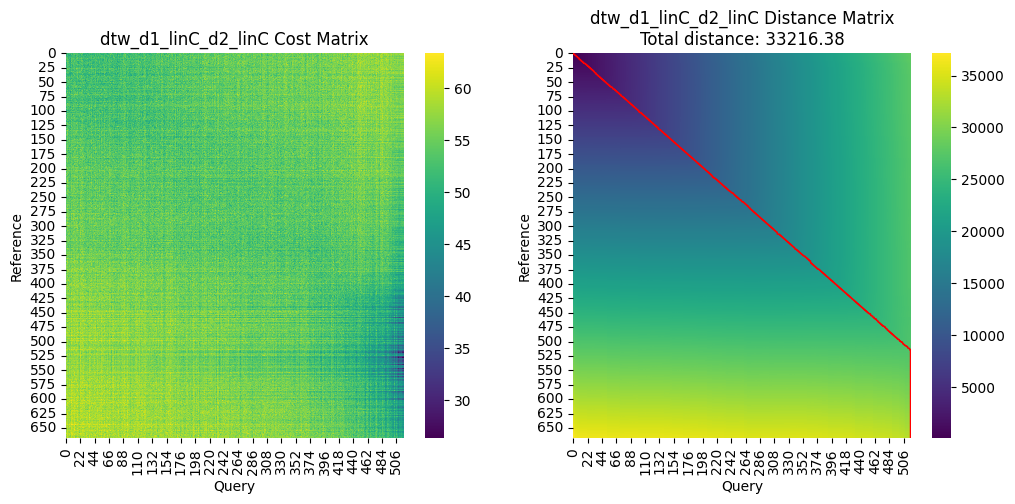

In [25]:
dynchronize(d1_linC, d2_linC, dtw_key="dtw_d1_linC_d2_linC", pseudotime_key="orig_pseudotime")

In [31]:
d1_linC.uns["dtw_d1_linC_d2_linC_path"]

cell952          [0]
cell530       [0, 1]
cell600    [1, 2, 3]
cell79           [3]
cell746    [3, 4, 5]
             ...    
cell395        [517]
cell737        [517]
cell543        [517]
cell469        [517]
cell730        [517]
Name: dtw_d1_linC_d2_linC_path, Length: 668, dtype: object

In [27]:
d1_linC.uns["dtw_d1_linC_d2_linC_path"] = d1_linC.obs["dtw_d1_linC_d2_linC_path"]
# d1_linC.uns["dtw_d1_linC_d2_linC_cells_path"] = d1_linC.obs["dtw_d1_linC_d2_linC_cells_path"]

In [28]:
del d1_linC.obs["dtw_d1_linC_d2_linC_path"]
del d1_linC.obs["dtw_d1_linC_d2_linC_cells_path"]

In [29]:
d1_linC.write_h5ad("data/dynchro1_linC_figures.h5ad")
d2_linC.write_h5ad("data/dynchro2_linC_figures.h5ad")

IORegistryError: No method registered for writing <class 'pandas.core.series.Series'> into <class 'h5py._hl.group.Group'>

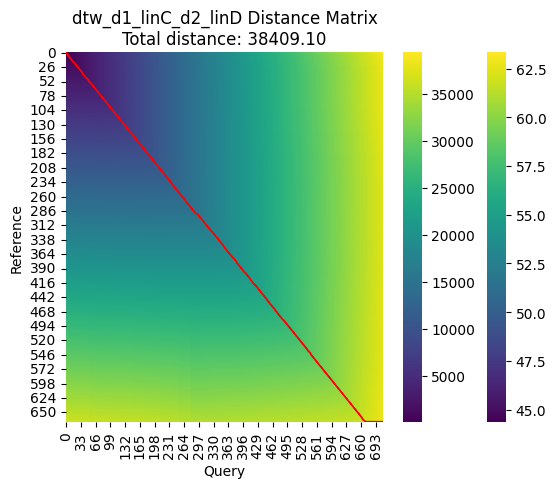

In [9]:
dynchronize(d1_linC, d2_linD, dtw_key="dtw_d1_linC_d2_linD", pseudotime_key="orig_pseudotime")

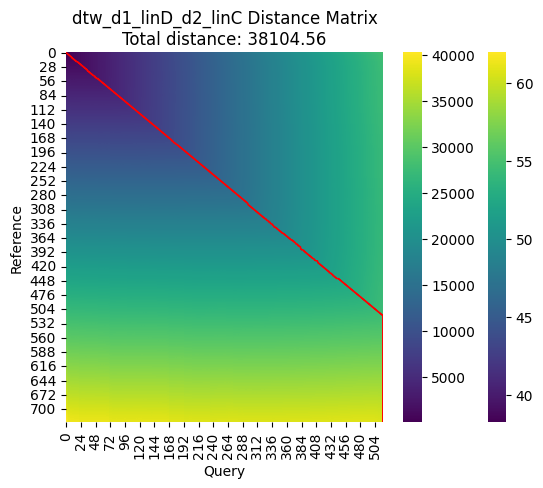

In [10]:
dynchronize(d1_linD, d2_linC, dtw_key="dtw_d1_linD_d2_linC", pseudotime_key="orig_pseudotime")

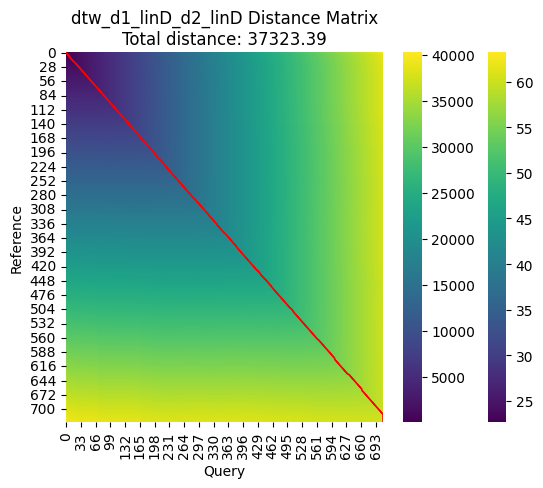

In [11]:
dynchronize(d1_linD, d2_linD, dtw_key="dtw_d1_linD_d2_linD", pseudotime_key="orig_pseudotime")

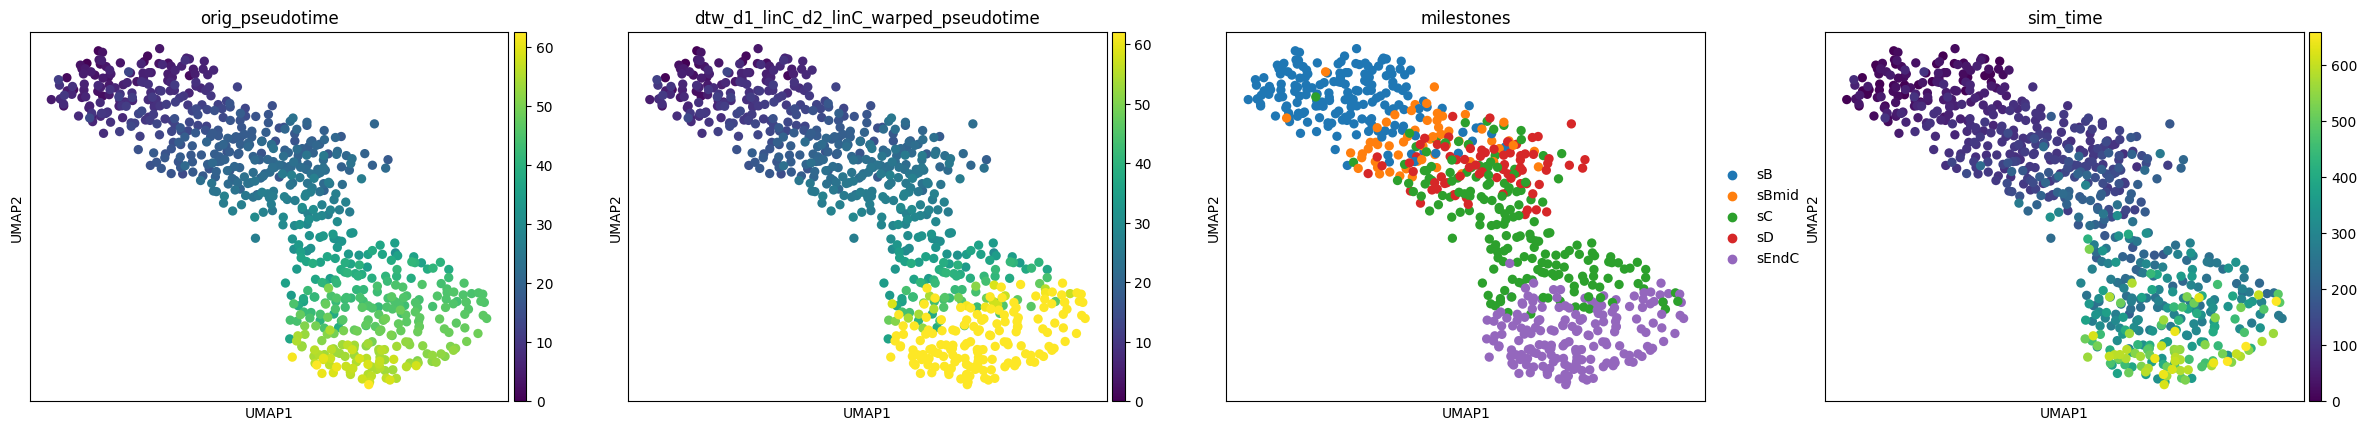

In [12]:
sc.pl.umap(d1_linC, color=["orig_pseudotime", "dtw_d1_linC_d2_linC_warped_pseudotime", "milestones", "sim_time"])

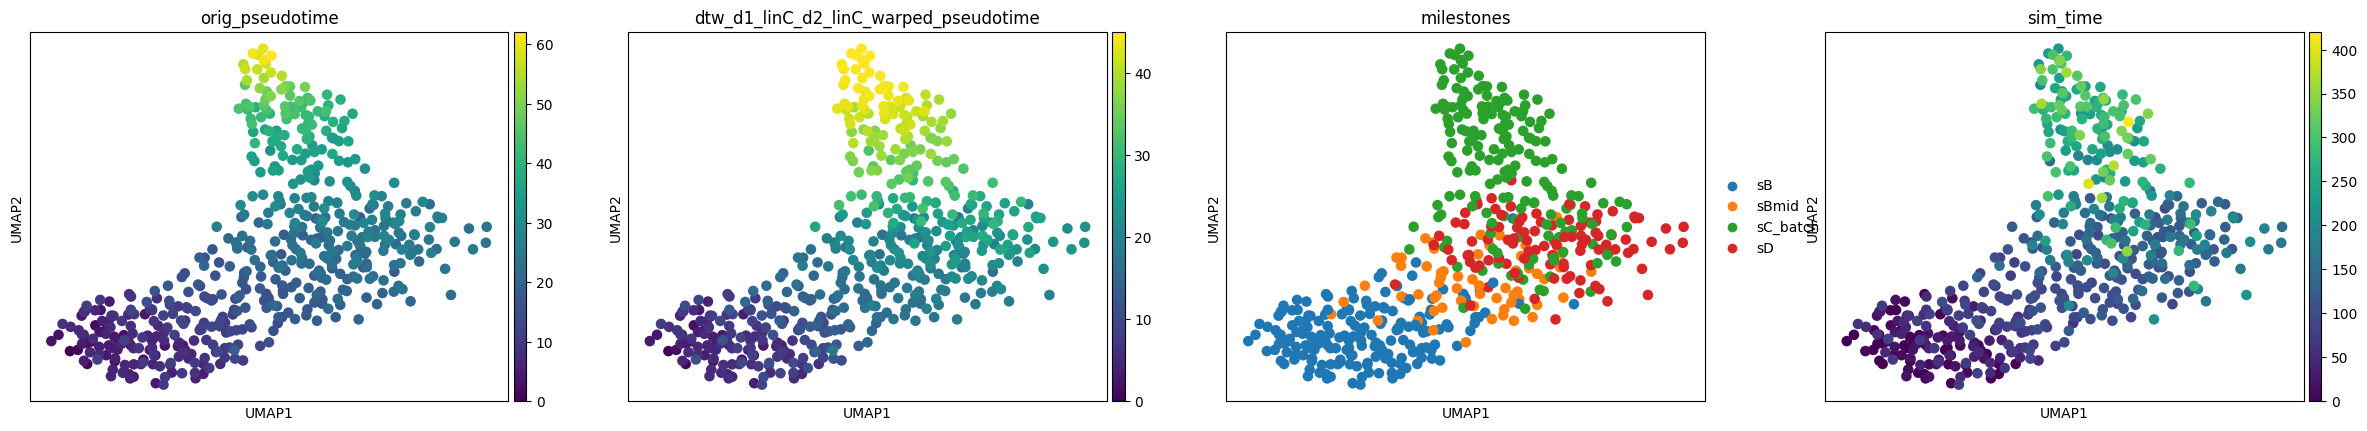

In [13]:
sc.pl.umap(d2_linC, color=["orig_pseudotime", "dtw_d1_linC_d2_linC_warped_pseudotime", "milestones", "sim_time"])

# 4. Compute metrics

In [14]:
linC = ad.concat([d1_linC, d2_linC], axis=0)
linD = ad.concat([d1_linD, d2_linD], axis=0)

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [15]:
# this should be stored in the object too, under uns[dtw_key_kde_x] and uns[dtw_key_kde_y]?
get_kde_eval(linC, "dtw_d1_linC_d2_linC_warped_pseudotime")
get_kde_eval(linC, "orig_pseudotime")

/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:19: UserWarning: Vector dtw_d1_linC_d2_linC_warped_pseudotime is not normalized between 0 and 1. Normalizing it now and storing as 'norm_dtw_d1_linC_d2_linC_warped_pseudotime'.
  warn(f"Vector {pseudotime_key} is not normalized between 0 and 1. Normalizing it now and storing as 'norm_{pseudotime_key}'.")
/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:19: UserWarning: Vector orig_pseudotime is not normalized between 0 and 1. Normalizing it now and storing as 'norm_orig_pseudotime'.
  warn(f"Vector {pseudotime_key} is not normalized between 0 and 1. Normalizing it now and storing as 'norm_{pseudotime_key}'.")


AnnData object with n_obs × n_vars = 1186 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'orig_pseudotime', 'dtw_d1_linC_d2_linC_path', 'dtw_d1_linC_d2_linC_cells_path', 'dtw_d1_linC_d2_linC_warped_pseudotime', 'norm_dtw_d1_linC_d2_linC_warped_pseudotime', 'norm_orig_pseudotime'
    uns: 'dtw_d1_linC_d2_linC_warped_pseudotime_kde', 'orig_pseudotime_kde'
    obsm: 'X_pca', 'X_umap', 'dimred', 'dtw_d1_linC_d2_linC_cost', 'dtw_d1_linC_d2_linC_D'
    layers: 'X', 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts'

In [16]:
endc_start = min(d1_linC[d1_linC.obs["milestones"] == "sEndC"].obs["orig_linC_pseudotime"])
min_pt = min(linC.obs["orig_pseudotime"])
max_pt = max(linC.obs["orig_pseudotime"])
endc_start_norm = (endc_start - min_pt) / (max_pt - min_pt)
endc_start_norm

0.5908188837727303

In [17]:
linC_dump = {
    "orig": [linC.uns["orig_pseudotime_kde"]["x"], linC.uns["orig_pseudotime_kde"]["y"]],
    "after": [linC.uns["dtw_d1_linC_d2_linC_warped_pseudotime_kde"]["x"], linC.uns["dtw_d1_linC_d2_linC_warped_pseudotime_kde"]["y"]],
    "cutoff": endc_start_norm,
}
import pickle
pickle.dump(linC_dump, open("data/dynchro.p", "wb"))

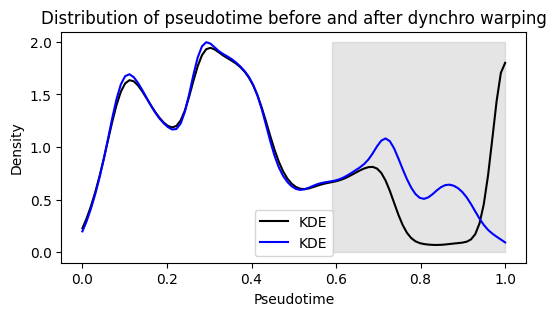

In [17]:
plot_kde_comparison(linC, ["dtw_d1_linC_d2_linC_warped_pseudotime", "orig_pseudotime"], cutoff = endc_start_norm,
                    title = "Distribution of pseudotime before and after dynchro warping")

In [18]:
c_wasserstein = get_wasserstein_distance(linC, pseudotime_keys = ["orig_pseudotime_kde", "dtw_d1_linC_d2_linC_warped_pseudotime_kde"])
print(f"Wasserstein distance before vs after C: {c_wasserstein}")

Wasserstein distance before vs after C: 0.02633810529281499


In [19]:
before, after = get_wasserstein_distance(linC, pseudotime_keys = ["orig_pseudotime_kde", "dtw_d1_linC_d2_linC_warped_pseudotime_kde"], cutoff = endc_start_norm)
print(f"Wasserstein distance before vs after C: {before} vs {after}")

Wasserstein distance before vs after C: 0.0012406836981447413 vs 0.05040988177083559


# 5. compute metrics separately

In [20]:
bw = 0.1

get_kde_eval(d1_linC, "dtw_d1_linC_d2_linC_warped_pseudotime", bandwidth=bw)
get_kde_eval(d1_linC, "orig_pseudotime", bandwidth=bw)
get_kde_eval(d2_linC, "dtw_d1_linC_d2_linC_warped_pseudotime", bandwidth=bw)
get_kde_eval(d2_linC, "orig_pseudotime", bandwidth=bw)

get_kde_eval(linC, "dtw_d1_linC_d2_linC_warped_pseudotime", bandwidth=bw)
get_kde_eval(linC, "orig_pseudotime", bandwidth=bw)

/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:19: UserWarning: Vector dtw_d1_linC_d2_linC_warped_pseudotime is not normalized between 0 and 1. Normalizing it now and storing as 'norm_dtw_d1_linC_d2_linC_warped_pseudotime'.
  warn(f"Vector {pseudotime_key} is not normalized between 0 and 1. Normalizing it now and storing as 'norm_{pseudotime_key}'.")
/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:19: UserWarning: Vector orig_pseudotime is not normalized between 0 and 1. Normalizing it now and storing as 'norm_orig_pseudotime'.
  warn(f"Vector {pseudotime_key} is not normalized between 0 and 1. Normalizing it now and storing as 'norm_{pseudotime_key}'.")
/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:19: UserWarning: Vector dtw_d1_linC_d2_linC_warped_pseudotime is not normalized between 0 and 1. Normalizing it now and storing as 'norm_dtw_d1_linC_d2_linC_warped_pseudotime'.
  warn(f"Vector {pseudotime_key} is not normalized between 0 and 1. Normalizing it now and storing 

AnnData object with n_obs × n_vars = 1186 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'orig_pseudotime', 'dtw_d1_linC_d2_linC_path', 'dtw_d1_linC_d2_linC_cells_path', 'dtw_d1_linC_d2_linC_warped_pseudotime', 'norm_dtw_d1_linC_d2_linC_warped_pseudotime', 'norm_orig_pseudotime'
    uns: 'dtw_d1_linC_d2_linC_warped_pseudotime_kde', 'orig_pseudotime_kde'
    obsm: 'X_pca', 'X_umap', 'dimred', 'dtw_d1_linC_d2_linC_cost', 'dtw_d1_linC_d2_linC_D'
    layers: 'X', 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts'

In [21]:
endc_start = min(d1_linC[d1_linC.obs["milestones"] == "sEndC"].obs["orig_linC_pseudotime"])

min_pt = min(d1_linC.obs["orig_pseudotime"])
max_pt = max(d1_linC.obs["orig_pseudotime"])

endc_start_norm = (endc_start - min_pt) / (max_pt - min_pt)
endc_start_norm

0.5908188837727303

In [28]:
bw = 0.1
pseudotimes =["orig_pseudotime", "dtw_d1_linC_d2_linC_warped_pseudotime"]
method = "dynchro"

both_orig, both_after, both_w1, both_w2, both_total = get_kdes_wasserstein(
    linC, linC, pseudotimes=pseudotimes, split = endc_start_norm, bw=bw
)

both_w1, both_w2, both_total

(np.float64(0.0012406836981447413),
 np.float64(0.05040988177083559),
 np.float64(0.02633810529281499))

In [29]:
bw = 0.1
pseudotimes =["orig_pseudotime", "dtw_d1_linC_d2_linC_warped_pseudotime"]
method = "dynchro"

# d1_b_linC = clin_before[clin_before.obs["batch"] == "control"]
# d2_b_linC = clin_before[clin_before.obs["batch"] == "premature stop"]

# d1_a_linC = clin_after[clin_after.obs["batch"] == "control"]
# d2_a_linC = clin_after[clin_after.obs["batch"] == "premature stop"]

res1_orig, res1_after, res1_w1, res1_w2, res1_total = get_kdes_wasserstein(
    d1_linC, d1_linC, pseudotimes=pseudotimes, split = endc_start_norm, bw=bw
)

res2_orig, res2_after, res2_w1, res2_w2, res2_total = get_kdes_wasserstein(
    d2_linC, d2_linC, pseudotimes=pseudotimes, split = endc_start_norm, bw=bw
)

both_orig, both_after, both_w1, both_w2, both_total = get_kdes_wasserstein(
    linC, linC, pseudotimes=pseudotimes, split = endc_start_norm, bw=bw
)

dump = {
    "d1": {
        "orig": res1_orig,
        "after": res1_after,
        "cutoff": endc_start_norm,
        "wasserstein": [res1_w1, res1_w2, res1_total]
    },
    "d2": {
        "orig": res2_orig,
        "after": res2_after,
        "cutoff": endc_start_norm,
        "wasserstein": [res2_w1, res2_w2, res2_total]
    },
    "both": {
        "orig": both_orig,
        "after": both_after,
        "cutoff": endc_start_norm,
        "wasserstein": [both_w1, both_w2, both_total]
    }
}
import pickle
pickle.dump(dump, open(f"data/{method}_dump.p", "wb"))

In [24]:
linC_dump = {
    "d1": {
        "orig": [d1_linC.uns["orig_pseudotime_kde"]["x"], d1_linC.uns["orig_pseudotime_kde"]["y"]],
        "after": [d1_linC.uns["dtw_d1_linC_d2_linC_warped_pseudotime_kde"]["x"], d1_linC.uns["dtw_d1_linC_d2_linC_warped_pseudotime_kde"]["y"]],
        "cutoff": endc_start_norm,
    },
    "d2": {
        "orig": [d2_linC.uns["orig_pseudotime_kde"]["x"], d2_linC.uns["orig_pseudotime_kde"]["y"]],
        "after": [d2_linC.uns["dtw_d1_linC_d2_linC_warped_pseudotime_kde"]["x"], d2_linC.uns["dtw_d1_linC_d2_linC_warped_pseudotime_kde"]["y"]],
        "cutoff": endc_start_norm,
    },
    "both": {
        "orig": [linC.uns["orig_pseudotime_kde"]["x"], linC.uns["orig_pseudotime_kde"]["y"]],
        "after": [linC.uns["dtw_d1_linC_d2_linC_warped_pseudotime_kde"]["x"], linC.uns["dtw_d1_linC_d2_linC_warped_pseudotime_kde"]["y"]],
        "cutoff": endc_start_norm,
    }
}
import pickle
pickle.dump(linC_dump, open("data/linC_dynchro.p", "wb"))

In [20]:
get_kde_eval(d2_linC, "dtw_d1_linC_d2_linC_warped_pseudotime")
get_kde_eval(d2_linC, "orig_pseudotime")

/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:19: UserWarning: Vector dtw_d1_linC_d2_linC_warped_pseudotime is not normalized between 0 and 1. Normalizing it now and storing as 'norm_dtw_d1_linC_d2_linC_warped_pseudotime'.
  warn(f"Vector {pseudotime_key} is not normalized between 0 and 1. Normalizing it now and storing as 'norm_{pseudotime_key}'.")
/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:19: UserWarning: Vector orig_pseudotime is not normalized between 0 and 1. Normalizing it now and storing as 'norm_orig_pseudotime'.
  warn(f"Vector {pseudotime_key} is not normalized between 0 and 1. Normalizing it now and storing as 'norm_{pseudotime_key}'.")


AnnData object with n_obs × n_vars = 518 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'orig_pseudotime', 'dtw_d1_linC_d2_linC_path', 'dtw_d1_linC_d2_linC_cells_path', 'dtw_d1_linC_d2_linC_warped_pseudotime', 'dtw_d1_linD_d2_linC_path', 'dtw_d1_linD_d2_linC_cells_path', 'dtw_d1_linD_d2_linC_warped_pseudotime', 'norm_dtw_d1_linC_d2_linC_warped_pseudotime', 'norm_orig_pseudotime'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
    uns: 'iroot', 'leiden', 'leiden_colors', 'log1p', 'milestones_colors', 'neighbors', 'pca', 'slingshot_end', 'slingshot_start', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions', 'umap', 'dtw_d1_lin

In [23]:
d2_linC.obs

,step_ix,simulation_i,sim_time,milestones,leiden,orig_linD_pseudotime,orig_linC_pseudotime,linD,linC,orig_pseudotime,dtw_d1_linC_d2_linC_path,dtw_d1_linC_d2_linC_cells_path,dtw_d1_linC_d2_linC_warped_pseudotime,dtw_d1_linD_d2_linC_path,dtw_d1_linD_d2_linC_cells_path,dtw_d1_linD_d2_linC_warped_pseudotime,norm_dtw_d1_linC_d2_linC_warped_pseudotime,norm_orig_pseudotime
cell977,7550,94,10.000000,sB,1,0.000000,0.000000,TRUE,TRUE,0.000000,"[0, 1]","[cell952, cell530]",0.000000,"[0, 1]","[cell952, cell530]",0.000000,0.000000,0.000000
cell393,3742,47,0.000000,sB,1,0.597302,0.597293,TRUE,TRUE,0.597293,"[1, 2]","[cell530, cell600]",0.768708,"[1, 2]","[cell530, cell600]",0.768788,0.017075,0.009627
cell589,2040,26,0.000000,sB,1,1.030036,1.030089,TRUE,TRUE,1.030089,[2],[cell600],1.501707,[2],[cell600],1.502508,0.033357,0.016603
cell324,3498,44,0.000000,sB,1,1.334011,1.335350,TRUE,TRUE,1.335350,"[2, 3, 4]","[cell600, cell79, cell746]",1.501707,"[2, 3, 4]","[cell600, cell79, cell746]",1.502508,0.033357,0.021523
cell200,1315,17,30.083333,sB,1,1.588800,1.590043,TRUE,TRUE,1.590043,[4],[cell746],1.755563,[4],[cell746],1.755199,0.038996,0.025628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell952,289,4,300.000000,sC_batch,4,NaN,58.520299,FALSE,TRUE,58.520299,"[510, 511, 512]","[cell368, cell754, cell791]",44.809654,"[512, 513]","[cell147, cell818]",31.824513,0.995355,0.943203
cell351,6599,82,220.000000,sC_batch,4,NaN,59.459960,FALSE,TRUE,59.459960,[512],[cell791],44.877181,"[513, 514]","[cell818, cell77]",31.896205,0.996855,0.958348
cell942,611,8,280.000000,sC_batch,4,NaN,60.716079,FALSE,TRUE,60.716079,"[512, 513]","[cell791, cell234]",44.877181,"[514, 515]","[cell77, cell311]",31.995213,0.996855,0.978594
cell797,2388,30,230.000000,sC_batch,4,NaN,61.069675,FALSE,TRUE,61.069675,"[513, 514, 515]","[cell234, cell339, cell159]",44.899655,"[515, 516]","[cell311, cell687]",32.085517,0.997355,0.984293


In [24]:
endc_start = min(d2_linC[d2_linC.obs["milestones"] == "sEndC"].obs["orig_linC_pseudotime"])
min_pt = min(d2_linC.obs["orig_pseudotime"])
max_pt = max(d2_linC.obs["orig_pseudotime"])
endc_start_norm = (endc_start - min_pt) / (max_pt - min_pt)
endc_start_norm

ValueError: min() iterable argument is empty

In [25]:
d2_linC_dump = {
    "orig": [d2_linC.uns["orig_pseudotime_kde"]["x"], d2_linC.uns["orig_pseudotime_kde"]["y"]],
    "after": [d2_linC.uns["dtw_d1_linC_d2_linC_warped_pseudotime_kde"]["x"], d2_linC.uns["dtw_d1_linC_d2_linC_warped_pseudotime_kde"]["y"]],
    "cutoff": endc_start_norm,
}
import pickle
pickle.dump(d2_linC_dump, open("data/d2_linC_dynchro.p", "wb"))